In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Read in data
data = pd.read_csv("data/data_prepped_r.csv")
X = data.drop("Target", axis=1)
y = data["Target"]

label_map = {"Dropout": 1, "Graduate": 0}
y_encoded = pd.Series([label_map[label] for label in y])

# Split train test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42)

print(f"Train-set length: {X_train.shape[0]}\nTest-set length {X_test.shape[0]}")
# Define feature types
categorical = [
    "Marital status",
    "Application mode",
    "Course",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
]

numeric = [col for col in X_train.columns if col not in categorical]

# Construc preprocessor to transform data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

Train-set length: 2904
Test-set length 726


## Models

In [4]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import joblib
from scipy.stats import uniform, randint

### Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
# Define search space
logreg_param_distributions = [
    # L1 and L2: no l1_ratio
    {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': uniform(0.01, 1.0),  # C between 0.01 and 1.01
        'classifier__class_weight': [None, 'balanced']
    },
    # ElasticNet: includes l1_ratio
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__C': uniform(0.01, 1.0),
        'classifier__l1_ratio': uniform(0.1, 0.9),  # between 0.1 and 1.0
        'classifier__class_weight': [None, 'balanced']
    }
]

# Pipeline
logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        solver='saga',
        max_iter=5000,
        random_state=42
    ))
])

# Randomized search
logreg_random_search = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=logreg_param_distributions,
    n_iter=1000,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit
logreg_random_search.fit(X_train, y_train)

print("Best parameters (LogReg):", logreg_random_search.best_params_)
print(f"Best log loss: {-logreg_random_search.best_score_:.3f}")

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
Best parameters (LogReg): {'classifier__C': np.float64(0.3892285849638004), 'classifier__class_weight': None, 'classifier__l1_ratio': np.float64(0.7670085843610531), 'classifier__penalty': 'elasticnet'}
Best log loss: 0.236


In [7]:
# Extract best parameters
best_logreg_params = logreg_random_search.best_params_

# Build fine-tuned grid
if best_logreg_params['classifier__penalty'] in ['l1', 'l2']:
    logreg_param_grid_refined = {
        'classifier__penalty': [best_logreg_params['classifier__penalty']],
        'classifier__C': [round(best_logreg_params['classifier__C'] * (1 + i * 0.2), 3) for i in [-1, 0, 1]],
        'classifier__class_weight': [best_logreg_params['classifier__class_weight']]
    }
else:  # elasticnet
    logreg_param_grid_refined = {
        'classifier__penalty': ['elasticnet'],
        'classifier__C': [round(best_logreg_params['classifier__C'] * (1 + i * 0.2), 3) for i in [-1, 0, 1]],
        'classifier__class_weight': [best_logreg_params['classifier__class_weight']],
        'classifier__l1_ratio': [round(best_logreg_params['classifier__l1_ratio'] + i * 0.05, 2) for i in [-1, 0, 1]]
    }

# Run fine-tuned grid search
logreg_grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=[logreg_param_grid_refined],  # wrap in list for multi-dict syntax
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=1
)

logreg_grid_search.fit(X_train, y_train)

print("Best parameters (LogReg):", logreg_grid_search.best_params_)
print(f"Best log loss: {-logreg_grid_search.best_score_:.3f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters (LogReg): {'classifier__C': np.float64(0.389), 'classifier__class_weight': None, 'classifier__l1_ratio': np.float64(0.82), 'classifier__penalty': 'elasticnet'}
Best log loss: 0.236


In [8]:
# Save the best estimator
joblib.dump(logreg_grid_search.best_estimator_, 'models/best_logreg_pipeline.joblib')

['models/best_logreg_pipeline.joblib']

In [9]:
# load best estimator
logreg_m = joblib.load("models/best_logreg_pipeline.joblib")

## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
# Define parameter distributions
rf_param_distributions = {
    "classifier__n_estimators": randint(500, 2000),
    "classifier__max_depth": randint(5, 30),
    "classifier__min_samples_leaf": randint(1, 10),
    "classifier__max_features": uniform(0.1, 0.9),  # 0.1 to 1.0
    "classifier__bootstrap": [True, False]
}

# Pipeline
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Randomized search
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_distributions,
    n_iter=50,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit
rf_random_search.fit(X_train, y_train)

print("Best parameters (RF):", rf_random_search.best_params_)
print(f"Best log loss: {-rf_random_search.best_score_:.3f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


Best parameters (RF): {'classifier__bootstrap': True, 'classifier__max_depth': 9, 'classifier__max_features': np.float64(0.35635644493972085), 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 1198}
Best log loss: 0.259


In [162]:
# Extract best parameters
best_rf_params = rf_random_search.best_params_

# Helper: Around function for int/float params
def around(val, step, n=1, limits=None):
    vals = [val + i * step for i in range(-n, n + 1)]
    if limits:
        vals = [max(min(v, limits[1]), limits[0]) for v in vals]
    return sorted(set(vals))

# Build fine-tuned grid
rf_param_grid_refined = {
    "classifier__n_estimators": around(best_rf_params["classifier__n_estimators"], 100, 1, (100, 2000)),
    "classifier__max_depth": around(best_rf_params["classifier__max_depth"], 2, 1, (2, 30)),
    "classifier__min_samples_leaf": around(best_rf_params["classifier__min_samples_leaf"], 1, 1, (1, 20)),
    "classifier__max_features": around(best_rf_params["classifier__max_features"], 0.05, 1, (0.1, 1.0)),
    "classifier__bootstrap": [best_rf_params["classifier__bootstrap"]]
}

# Run refined grid search
rf_grid_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid_refined,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print("Best parameters (RF):", rf_grid_search.best_params_)
print(f"Best log loss: {-rf_grid_search.best_score_:.3f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits


KeyboardInterrupt: 

In [13]:
# Save the best estimator
joblib.dump(rf_random_search.best_estimator_, 'models/best_rf_pipeline.joblib')

['models/best_rf_pipeline.joblib']

In [14]:
rf_m = joblib.load('models/best_rf_pipeline.joblib')

### XGBoost

In [15]:
import xgboost as xgb

In [23]:
# Create pipeline
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("classifier", xgb.XGBClassifier(
        eval_metric="logloss",
        random_state=42,
    ))
])

# Reasonable hyperparameter distributions for randomized search
xgb_param_distributions = {
    "classifier__learning_rate": uniform(0.01, 0.2),  # 0.01 to 0.21
    "classifier__n_estimators": randint(100, 1000),   # 100 to 999
    "classifier__max_depth": randint(3, 10),          # 3 to 9
    "classifier__reg_lambda": uniform(0, 1),          # 0 to 1
    "classifier__colsample_bytree": uniform(0.3, 0.7) # 0.3 to 1.0
}

# Randomized search with cross-validation
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_distributions,
    n_iter=100,  # number of random combinations to try
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=1,
    #random_state=42
)

# Fit model with 3-fold CV
xgb_random_search.fit(X_train, y_train)

print(f"Best parameters: {xgb_random_search.best_params_}")
print(f"Best cross-validation log loss: {-xgb_random_search.best_score_:.3f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'classifier__colsample_bytree': np.float64(0.5121677722427447), 'classifier__learning_rate': np.float64(0.08850231742688347), 'classifier__max_depth': 3, 'classifier__n_estimators': 165, 'classifier__reg_lambda': np.float64(0.5636821922491041)}
Best cross-validation log loss: 0.241


In [20]:
# Extract best parameters from randomized search
best_params = xgb_random_search.best_params_

# Helper function to create a small grid around a numeric value
def around(val, step=0.01, n=1, limits=(0, 1)):
    return sorted(set([
        max(min(val + i * step, limits[1]), limits[0])
        for i in range(-n, n + 1)
    ]))

# Build fine-tuned grid around best parameters
xgb_param_grid_refined = {
    "classifier__learning_rate": around(best_params["classifier__learning_rate"], step=0.01, n=1, limits=(0.001, 0.3)),
    "classifier__n_estimators": around(best_params["classifier__n_estimators"], step=50, n=1, limits=(50, 1500)),
    "classifier__max_depth": around(best_params["classifier__max_depth"], step=1, n=1, limits=(2, 15)),
    "classifier__reg_lambda": around(best_params["classifier__reg_lambda"], step=0.1, n=1, limits=(0.0, 5.0)),
    "classifier__colsample_bytree": around(best_params["classifier__colsample_bytree"], step=0.05, n=1, limits=(0.1, 1.0)),
}

# Grid search with cross-validation
xgb_grid_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_param_grid_refined,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=1
)

# Fit model with 3-fold CV
xgb_grid_search.fit(X_train, y_train)

print(f"Best parameters from fine-tuned grid: {xgb_grid_search.best_params_}")
print(f"Best cross-validation log loss: {-xgb_grid_search.best_score_:.3f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters from fine-tuned grid: {'classifier__colsample_bytree': np.float64(0.31627903536453533), 'classifier__learning_rate': np.float64(0.03929008106533783), 'classifier__max_depth': 4, 'classifier__n_estimators': 249, 'classifier__reg_lambda': np.float64(0.8596172013190873)}
Best cross-validation log loss: 0.238


In [21]:
# Save the best estimator
joblib.dump(xgb_grid_search.best_estimator_, 'models/best_xgb_pipeline.joblib')

['models/best_xgb_pipeline.joblib']

In [25]:
xgb_m = joblib.load("models/best_xgb_pipeline.joblib")

## Simple Average Ensemble

In [ ]:
import itertools

In [ ]:
class StudentDropoutEnsemble:
    """
    Ensemble utilities for Logistic Regression, Random Forest and XGBoost
    dropout-risk models.[1]
    """

    def __init__(self, logistic_model, rf_model, xgb_model):
        self.models = {
            'LogReg': logistic_model,
            'RF'    : rf_model,
            'XGB'   : xgb_model
        }

    # ------------------------------------------------------------------ #
    # internal helper
    # ------------------------------------------------------------------ #
    def _get_prob_vectors(self, X):
        """Return a dict {model_name : 1-D numpy array of P(dropout)}"""
        return {name: mdl.predict_proba(X)[:, 1] for name, mdl in self.models.items()}


    def average_combinations(self, X, min_models=1):
        """
        Compute simple-average probabilities for every model combination.

        Parameters
        ----------
        X : array-like
            Feature matrix.
        min_models : int, default=1
            Smallest subset size to consider.
            * 1  → include single models as well
            * 2  → only pairwise and triple combinations, etc.

        Returns
        -------
        dict
            Keys  : e.g. 'LogReg', 'RF_XGB', 'LogReg_RF_XGB'
            Values: numpy array with averaged probabilities for that subset.
        """
        prob_dict   = self._get_prob_vectors(X)
        combo_probs = {}

        for r in range(min_models, len(prob_dict) + 1):
            for combo in itertools.combinations(prob_dict.keys(), r):
                name              = '_'.join(combo)      # readable key
                combo_matrix      = [prob_dict[m] for m in combo]
                combo_probs[name] = np.mean(combo_matrix, axis=0)

        return combo_probs

In [102]:
ensemble = StudentDropoutEnsemble(logreg_m, rf_m, xgb_m)
avg_comb_probs = ensemble.average_combinations(X_test, 2)

In [103]:
from sklearn.metrics import log_loss

# Define model names and threshold
model_cols = list(avg_comb_probs.keys())
threshold = 0.5

# Initialize list to collect metric results
metrics_list = []

# Compute metrics for each model
for model in model_cols:
    y_probs = avg_comb_probs[model]
    y_pred = (y_probs >= threshold).astype(int)
    
    metrics = {
        'Model': model,
        'Log Loss': log_loss(y_test, y_probs)
    }
    metrics_list.append(metrics)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Format numbers to 3 decimals (optional)
metrics_df = metrics_df.round(3)

# Display table
print(metrics_df)

           Model  Log Loss
0      LogReg_RF     0.236
1     LogReg_XGB     0.228
2         RF_XGB     0.244
3  LogReg_RF_XGB     0.234


## Model Results

In [104]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score
)

In [108]:
# Predict class probabilities
y_proba = pd.DataFrame(logreg_m.predict_proba(X_test)[:,1], columns=["LogReg"])
y_proba["RF"] = rf_m.predict_proba(X_test)[:,1]
y_proba["XGB"] = xgb_m.predict_proba(X_test)[:,1]
y_proba["Simple Average Ensemble"] = avg_comb_probs["LogReg_XGB"]
y_proba["True Label"] = y_test.values[:len(y_proba)]
y_proba.head()

,LogReg,RF,XGB,Simple Average Ensemble,True Label
0,0.396552,0.622757,0.578630,0.487591,0
1,0.846131,0.698579,0.867704,0.856917,1
2,0.993454,0.921249,0.968994,0.981224,1
3,0.092478,0.133599,0.067609,0.080043,0
4,0.998621,0.998773,0.993878,0.996250,1


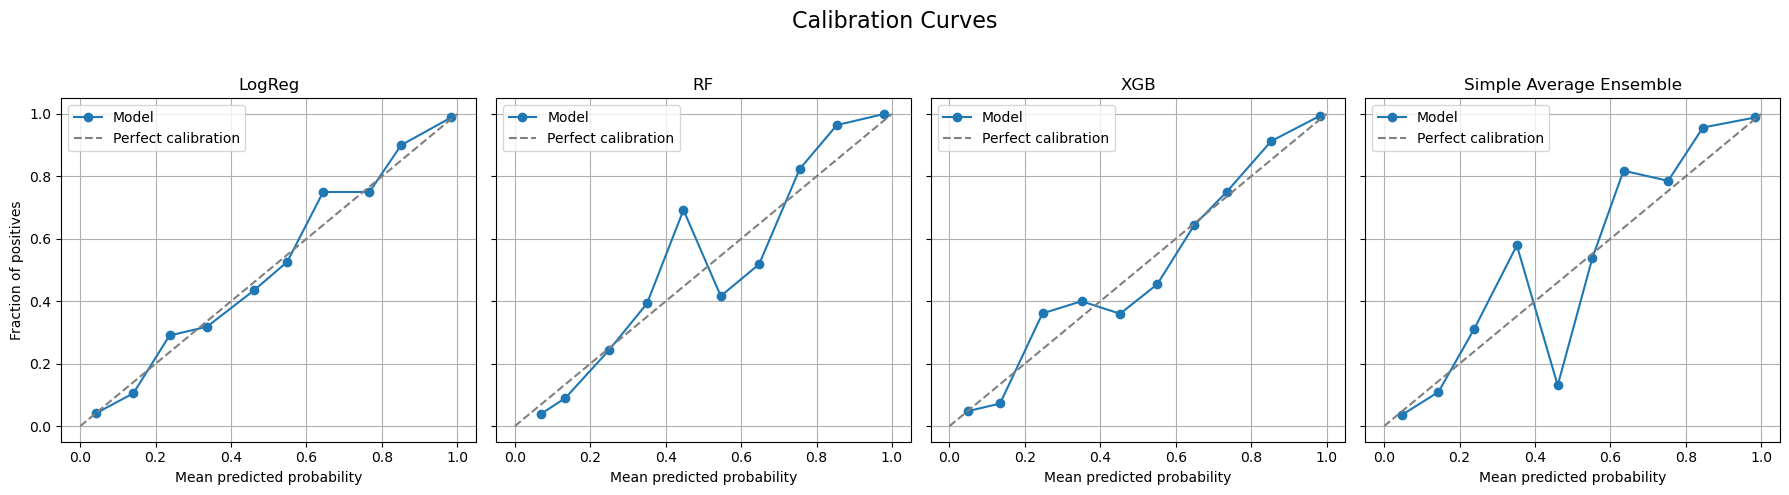

LogReg – Brier: 0.0679, Log Loss: 0.2325
RF – Brier: 0.0757, Log Loss: 0.2580
XGB – Brier: 0.0698, Log Loss: 0.2355
Simple Average Ensemble – Brier: 0.0666, Log Loss: 0.2283


In [109]:
models = [
    'LogReg',
    'RF',
    'XGB',
    'Simple Average Ensemble'
]

# Setup plot
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)

for i, name in enumerate(models):
    # Calibration curve on calibration set
    prob_true, prob_pred = calibration_curve(y_proba["True Label"], y_proba[name], n_bins=10)
    
    axes[i].plot(prob_pred, prob_true, 'o-', label='Model')
    axes[i].plot([0, 1], [0, 1], '--', color='gray', label='Perfect calibration')
    
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Mean predicted probability')
    if i == 0:
        axes[i].set_ylabel('Fraction of positives')
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle('Calibration Curves', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print Brier score and log loss on test set
for name in models:
    brier = brier_score_loss(y_test, y_proba[name])
    lloss = log_loss(y_test, y_proba[name])
    print(f'{name} – Brier: {brier:.4f}, Log Loss: {lloss:.4f}')

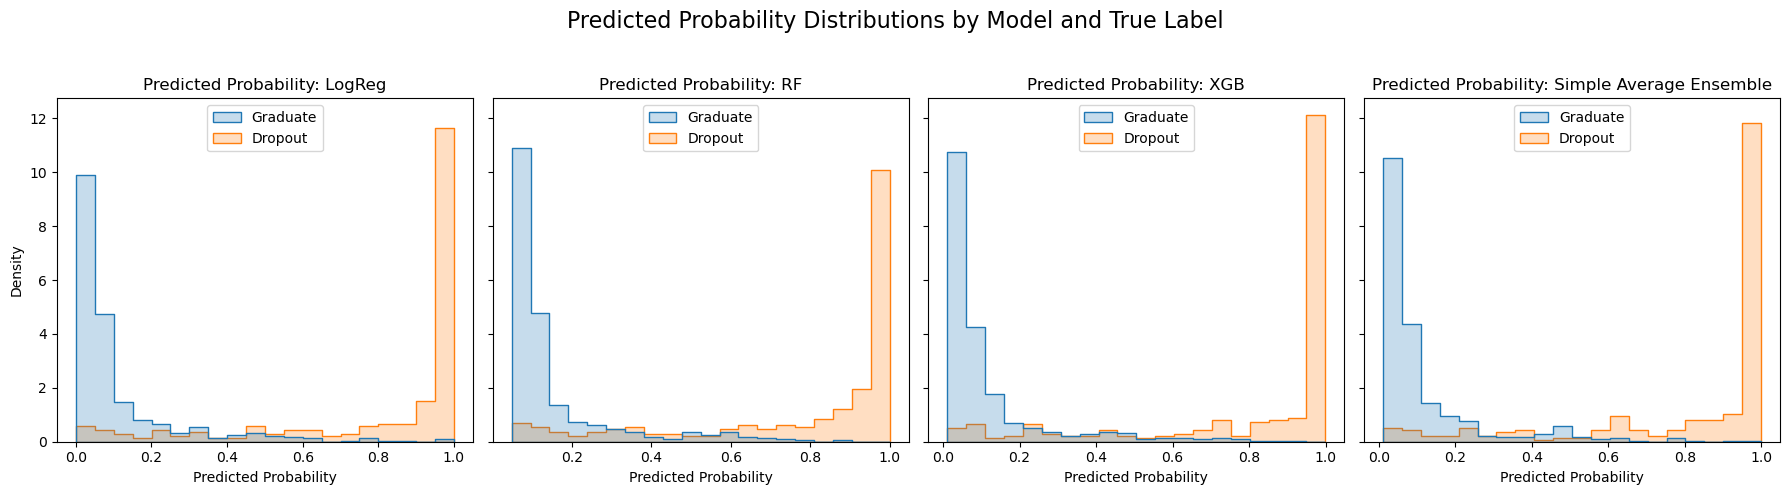

In [110]:
# List of model probability column names
model_cols = ['LogReg', 'RF', 'XGB', 'Simple Average Ensemble']
custom_legend_labels = ["Graduate", "Dropout"]

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)

for i, model in enumerate(model_cols):
    sns.histplot(
        data=y_proba,
        x=model,
        hue='True Label',
        element='step',
        stat='density',
        common_norm=False,
        bins=20,
        ax=axes[i]
    )
    axes[i].set_title(f'Predicted Probability: {model}')
    axes[i].set_xlabel('Predicted Probability')
    if i == 0:
        axes[i].set_ylabel('Density')
    else:
        axes[i].set_ylabel('')
    
    legend = axes[i].get_legend()
    if legend is not None:
        legend.set_title("")
        for text, new_label in zip(legend.get_texts(), custom_legend_labels):
            text.set_text(new_label)

            legend.set_loc('upper center')

plt.suptitle('Predicted Probability Distributions by Model and True Label', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


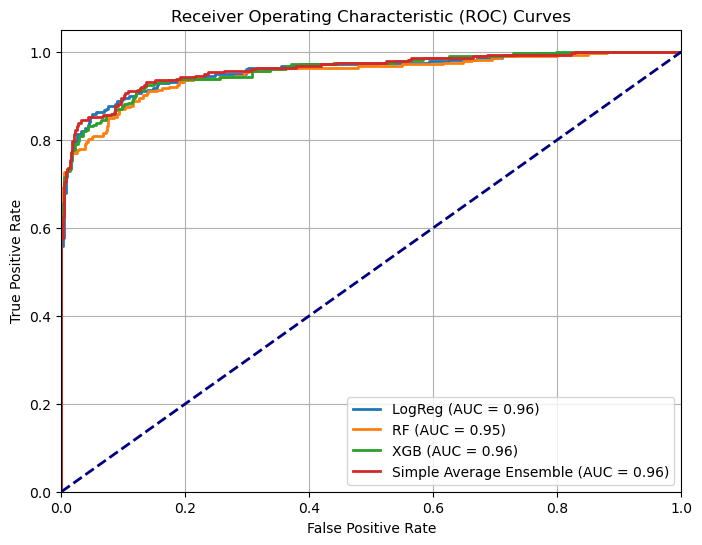

In [111]:
plt.figure(figsize=(8, 6))
for model_name, y_probs in y_proba.drop("True Label", axis=1).items():
    fpr, tpr, _ = roc_curve(y_proba["True Label"], y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

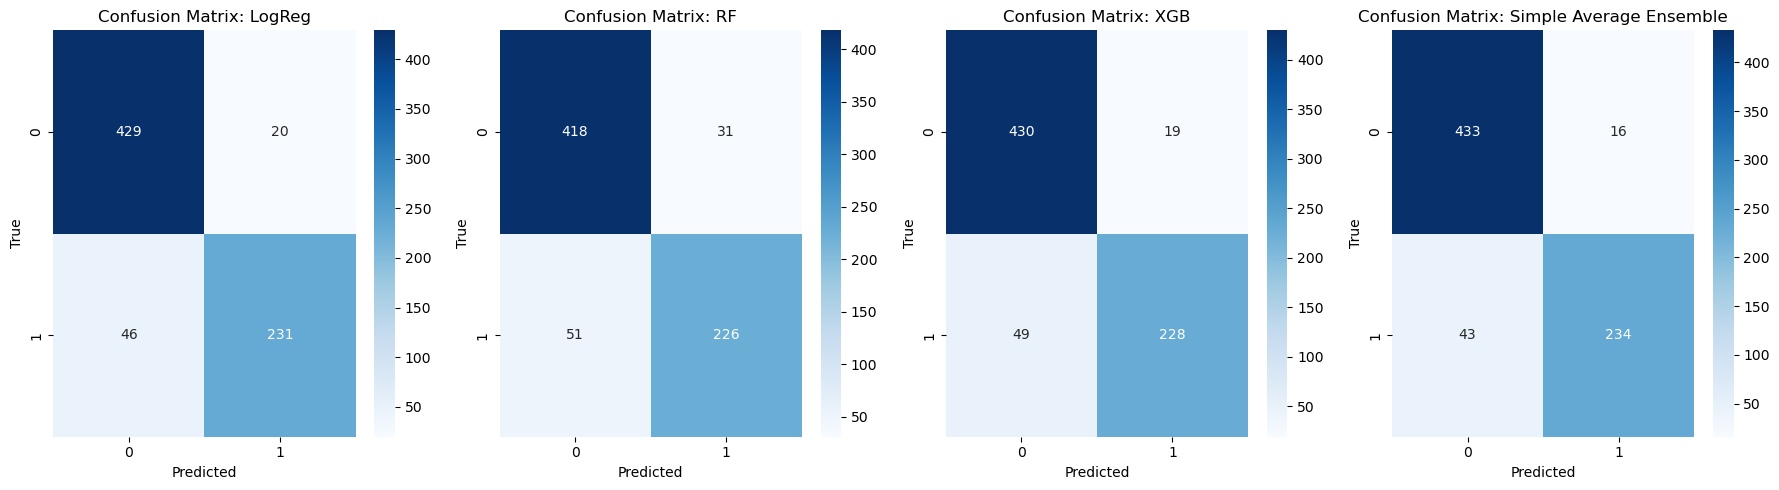

In [112]:
# Define model names and thresholds for converting probabilities to predicted classes
model_cols = ['LogReg', 'RF', 'XGB', 'Simple Average Ensemble']
threshold = 0.5  # adjust if needed

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for i, model in enumerate(model_cols):
    # Convert predicted probabilities to class labels
    y_pred = (y_proba[model] >= threshold).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[0, 1],
        yticklabels=[0, 1],
        ax=axes[i]
    )
    
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix: {model}')

plt.tight_layout()
plt.show()


In [116]:
# Define model names and threshold
model_cols = ['LogReg', 'RF', 'XGB', 'Simple Average Ensemble']
threshold = 0.1

# Initialize list to collect metric results
metrics_list = []

# Compute metrics for each model
for model in model_cols:
    y_probs = y_proba[model]
    y_pred = (y_probs >= threshold).astype(int)
    
    metrics = {
        'Model': model,
        'F1 Score': f1_score(y_test, y_pred),
        'Log Loss': log_loss(y_test, y_probs),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
    }
    metrics_list.append(metrics)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Format numbers to 3 decimals (optional)
metrics_df = metrics_df.round(3)

# Display table
print(metrics_df)

                     Model  F1 Score  Log Loss  Accuracy  Precision  Recall
0                   LogReg     0.796     0.233     0.814      0.685   0.949
1                       RF     0.716     0.258     0.708      0.569   0.964
2                      XGB     0.780     0.236     0.798      0.666   0.942
3  Simple Average Ensemble     0.797     0.228     0.814      0.683   0.957
